# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports-and-requirements" data-toc-modified-id="Imports-and-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and requirements</a></div><div class="lev1 toc-item"><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></div><div class="lev2 toc-item"><a href="#Loading-resistivity-data" data-toc-modified-id="Loading-resistivity-data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading resistivity data</a></div><div class="lev2 toc-item"><a href="#Loading-ERT-model-spatial-grid" data-toc-modified-id="Loading-ERT-model-spatial-grid-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading ERT model spatial grid</a></div><div class="lev2 toc-item"><a href="#Plot-of-the-mean-resistivities" data-toc-modified-id="Plot-of-the-mean-resistivities-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot of the mean resistivities</a></div><div class="lev1 toc-item"><a href="#Clustering" data-toc-modified-id="Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clustering</a></div><div class="lev2 toc-item"><a href="#Generic-function" data-toc-modified-id="Generic-function-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generic function</a></div><div class="lev2 toc-item"><a href="#Example:-HAC-without-connectivity-constraint" data-toc-modified-id="Example:-HAC-without-connectivity-constraint-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Example: HAC without connectivity constraint</a></div><div class="lev2 toc-item"><a href="#Example:--HAC-with-connectivity-constraint" data-toc-modified-id="Example:--HAC-with-connectivity-constraint-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Example:  HAC with connectivity constraint</a></div><div class="lev2 toc-item"><a href="#Example:-K-means-on-raw-resistivity" data-toc-modified-id="Example:-K-means-on-raw-resistivity-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Example: K-means on raw resistivity</a></div>

This notebook is associated with the scientific paper submitted to *Journal of Applied Geophysics*:

> Delforge, D. Watlet, A., Kaufmann, O., Van Camp, M., Vanclooster, M., 2019. Time-series clustering approaches for subsurface zonation and hydrofacies detection using a real time-lapse electrical resistivity dataset, submitted at Journal of Applied Geophysics. 

It provides code recipes to get hands-on the clustering of time-lapse ERT data. First,the data structure relying on [pandas](https://pandas.pydata.org/) is presented, and we show how to represent the mean resistivity spatially using the plotting library [`matplotlib`](https://matplotlib.org/). Then, relying on [sklearn](https://scikit-learn.org/), we show how to perform the clustering, apply clustering evaluation metrics, and display the results. 

# Imports and requirements

In [29]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import sklearn
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_mutual_info_score

# Programming environment
print(f'Python {sys.version}')
for lib in [pd, np, mpl, sklearn]:
    print(f'{lib.__name__}:{lib.__version__}')

Python 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]
pandas:2.2.3
numpy:1.26.4
matplotlib:3.10.0
sklearn:1.6.1


# Data

The original ERT Data is publicly available from Watlet et al. (2018):
> Watlet, A., Kaufmann, O., Triantafyllou, A., Poulain, A., Chambers, J.E., Meldrum, P.I., Wilkinson, P.B., Hallet, V., Quinif, Y., Van Ruymbeke, M., Van Camp, M., 2018. Data And Results For Manuscript Imaging Groundwater Infiltration Dynamics In Karst Vadose Zone With Long-Term Ert Monitoring. https://doi.org/10.5281/zenodo.1158631


In this case, the inverted ERT time-lapse data are stored in the `ert_resistivity.csv` file. The file is opened using the `pandas.read_csv` method, which creates a `pandas.DataFrame` object containing the data. The dataframe has 465 rows and 1558 columns. Each row is referring to a time step and each column corresponds to a cell identifier `cid` of the ERT spatial grid. Hence, each column holds a resistivity time-series corresponding to a specific cell. 

The geometrical properties of the ERT cells are described in the file `ert_geometry.csv`. Each row is indexed with the cell identifier `cid`. Each cell consists of a triangle polygon. The geometry dataframe has 4 columns. The three first are referencing the 3 edges unique identifiers (`eid1`, `eid2`, `eid3`). The edge identifiers are useful to assess if two ERT cells are adjacent. The last columns `xy` contains the geometry of the polygon characterized by four X and Y coordinates expressed in meters relative to the first electrode of the ERT profile. The last coordinate is the same as the first one and closes the triangle geometry. Such a formulation of the geometries is directly interpretable by the `matplotlib.patches.Polygon` method and thus allows creating a chart of ERT profile.

## Loading resistivity data

In [30]:
resdf = pd.read_csv('ert_resistivity.csv', index_col=0, parse_dates=[0])
resdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 465 entries, 2014-02-12 to 2017-03-09
Columns: 1558 entries, 0 to 1557
dtypes: float64(1558)
memory usage: 5.5 MB


## Loading ERT model spatial grid

In [31]:
geometry = pd.read_csv('ert_geometry.csv', index_col=0)
# parsing geometry into matplotlib polygons
geom = geometry['xy'].apply(lambda x: Polygon(np.array(eval(x))))

## Example: Plot of the mean resistivities

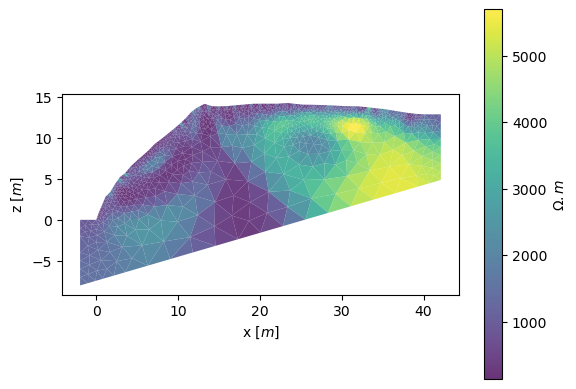

In [32]:
fig = plt.figure() # create figure
ax = fig.gca() # get figure axes
ax.set_aspect('equal') # use the same scale for both axis

p = PatchCollection(geom, alpha=0.8) # create the ERT grid
# set color
colors = resdf.mean() 
p.set_array(np.array(colors))
ax.add_collection(p)
ax.autoscale() # rescale axes
# add colorbar
cbar = fig.colorbar(p, ax=ax)
# add axes labels
_ = ax.set_xlabel('x [$m$]')
_ = ax.set_ylabel('z [$m$]')
_ = cbar.ax.set_ylabel('$\Omega.m$')

# Clustering

We illustrate the clustering using [hierarchical agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) (HAC). Still, the user can choose [any sklearn clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) with the same programming interface.

## Data z-standardization

The data are z-standardized such that the clustering will reflect correlated resistivity series. 

In [33]:
zdf = (resdf - resdf.mean())/resdf.std()

## Selecting the number of cluster

We vary the number of cluster $k$ between 2 and 10, and compute the [Silhouette Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) (SI) to find an optimal number of clusters. 

In [34]:
si_arr = [] # array storing SI values

for k in range(2, 11):
    # perform the clustering
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(zdf.T) # Tranposed because variable need to be columns
    si = silhouette_score(zdf.T, clusters)
    si_arr.append(si)

Text(0, 0.5, 'SI [0-1]')

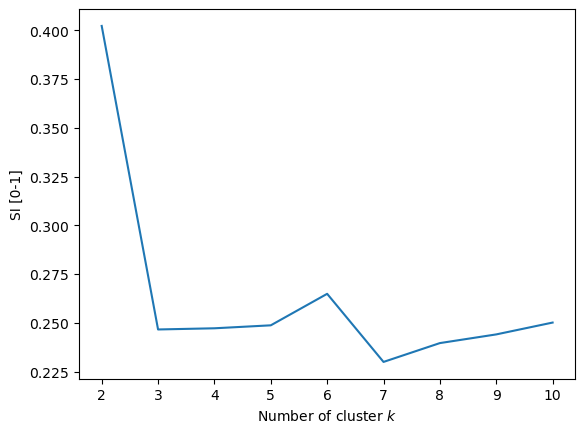

In [35]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), si_arr)
ax.set_xlabel('Number of cluster $k$')
ax.set_ylabel('SI [0-1]')

## Spatial distribution of cluster

The number of 6 clusters is selected as a relevant local optimum. The figure below reports the spatial organization of clusters. The white edges represent negative Silhouette values obtained with the [`silhouette_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) method. 

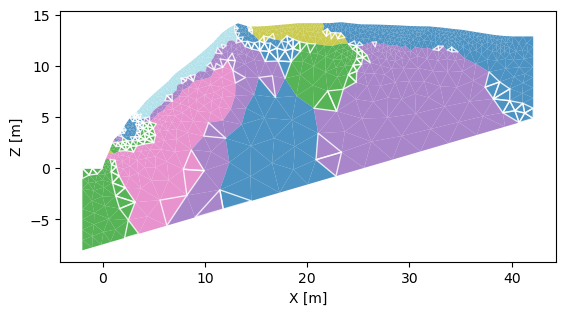

In [37]:
clusters = AgglomerativeClustering(n_clusters=6).fit_predict(zdf.T)

fig, ax = plt.subplots()
p = PatchCollection(geom, cmap='tab20', alpha=0.8)
p.set_array(np.array(clusters))
ax.add_collection(p)


sample_silhouette_values = silhouette_samples(zdf.T, clusters)
outliers = sample_silhouette_values < 0
p2 = PatchCollection(geom[outliers], edgecolor='w', facecolor="None",  alpha=0.8)
ax.add_collection(p2)

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
ax.set_aspect('equal')
ax.autoscale()

## Cluster averaged time-series

We group the log10 resistivity series using the `clusters` labels and average them using the `.mean()` method. The time-series are resampled by days ('D') such that no data appears clearly in the plot. The same colormap `tab20` is used such that it maps to the colors of the spatial distribution above. 

C:\Users\AQ96560\AppData\Local\Temp\ipykernel_15432\2850784373.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ts = np.log10(resdf).groupby(clusters, axis=1).mean().resample('D').mean()


Text(0, 0.5, 'log-resistivity')

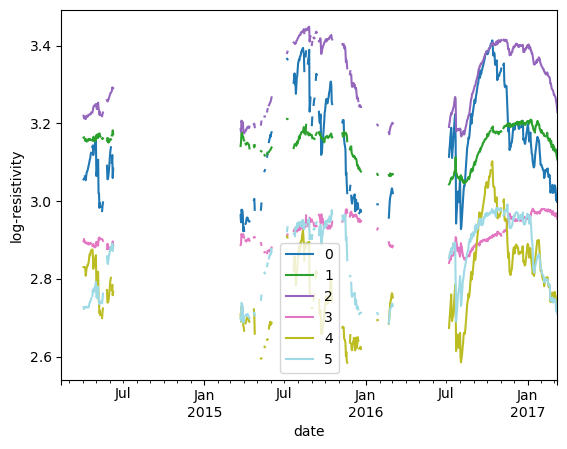

In [22]:
# time-series
ts = np.log10(resdf).groupby(clusters, axis=1).mean().resample('D').mean() 
ax = ts.plot(cmap='tab20')
ax.set_ylabel('log-resistivity')

## Cluster statistics

The next scatterplot reports log-resistivity series statistics with color matching to the cluster labels. 

Text(0, 0.5, '$\\sigma[log(\\rho)]$ [-]')

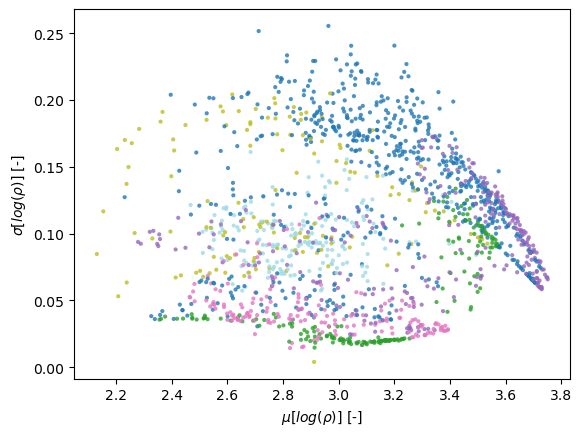

In [23]:
fig, ax = plt.subplots()
mu = np.log10(resdf).mean()
sigma = np.log10(resdf).std()
sc = ax.scatter(mu, sigma, marker='.', alpha=0.8, c=clusters, cmap='tab20', edgecolor='None', facecolor='None')
ax.set_xlabel('$\mu[log(\\rho)]$ [-]')
ax.set_ylabel('$\sigma[log(\\rho)]$ [-]')

## Clustering with spatial connectivity constraint

### Connectivity matrix

The binary connectivity matrix (1558x1558) is constructed such that the agglomeration occur only between cells that have an edge in common.

number of connections: 4494


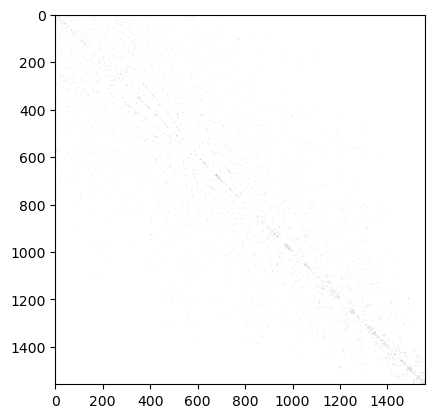

In [24]:
# building connectivity matrix
con_matrix = np.zeros((len(geom), len(geom)))
edge_df = geometry[['eid1', 'eid2', 'eid3']]

for i, edges in edge_df.iterrows():
    for e in edges:
        con_matrix[i] += (edge_df.values==e).any(axis=1)

# remove cells connected to itself
np.fill_diagonal(con_matrix, 0)
con_matrix[con_matrix < 2] = 0
con_matrix[con_matrix > 1.] = 1.
print(f'number of connections: {int(con_matrix.sum())}')
plt.imshow(con_matrix, cmap='binary')

### Clusering with connectivity

The connectivity matrix `con_matrix` is simply passed as an argument in the `AgglomerativeClustering` method. We let the value of k=6 to compare the difference. 

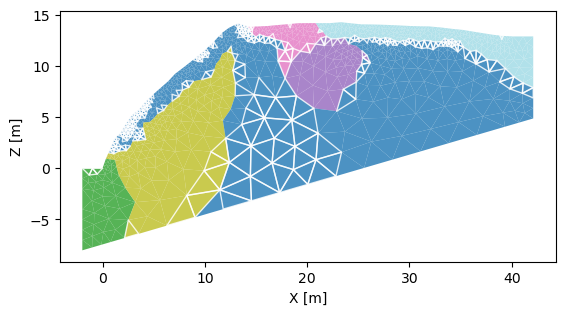

In [25]:
clusters = AgglomerativeClustering(n_clusters=6, connectivity=con_matrix).fit_predict(zdf.T)

fig, ax = plt.subplots()
p = PatchCollection(geom, cmap='tab20', alpha=0.8)
p.set_array(np.array(clusters))
ax.add_collection(p)


sample_silhouette_values = silhouette_samples(zdf.T, clusters)
outliers = sample_silhouette_values < 0
p2 = PatchCollection(geom[outliers], edgecolor='w', facecolor="None",  alpha=0.8)
ax.add_collection(p2)

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
ax.set_aspect('equal')
ax.autoscale()

## Similarity of clustering partitions

The similarity between two partitions can be compared with the [adjusted_mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) method (AMI). The average method 'max' is the one used in the paper, but it is not the default anymore in sklearn. AMI similarity ranges between 1 (identical) to 0 (the score of random partitions). Here, we compare the clustering with k=6 with and without connectivity constraint as shown above.

In [26]:
clusters_1 = AgglomerativeClustering(n_clusters=6, connectivity=None).fit_predict(zdf.T)
clusters_2 = AgglomerativeClustering(n_clusters=6, connectivity=con_matrix).fit_predict(zdf.T)

ami = adjusted_mutual_info_score(clusters_1, clusters_2, average_method='max')

print(f'Adjusted mutual Information: {ami}')

Adjusted mutual Information: 0.5428504448267624
